# **Art Classifier**

## **UnStructured Data**

This project has been done by:

|Name                    |Email                              |
|------------------------|-----------------------------------|
|Jorge Ayuso Martínez    |jorgeayusomartinez@alu.comillas.edu|
|Carlota Monedero Herranz|carlotamoh@alu.comillas.edu        |
|José Manuel Vega Gradit |josemanuel.vega@alu.comillas.edu   |

The main objective of this project is building an Art Classifier leveraging Deep Learning techniques. Data is available at kaggle in the following URL: https://www.kaggle.com/datasets/sivarazadi/wikiart-art-movementsstyles. For the sake of simplicity and disk limitations in our computers, we will only be classifying 4 of the available movement styles: Romanticism, Realism, Renacentism and Baroque. 

We will first start by building a simple Deep Neural Net architecture, which will serve as our basis model for reference and comparison. We will then try to extend its capabilities by using a two-step approach:

+ First, we will increase complexity by increasing the number of hyperparameters in the network until accuracy in training set is high enough and clear signs of overfitting are observed. 
+ Secondly, we will reduce overfitting of the complex model using techniques such as upsampling using data augmentation, regularization techniques such as $L_1$, $L_2$ and dropout.

Once our custom.built model is fully explored, we will then shift our focus towards using transfer learning based on the convolutional part of an off-the-shelf pre-trained network, which we will then combine with a fully connected classifier (DNN). Depending on the achieved performance, we can potentially consider unfreezing one or two of the last convolutional layers to allow for more specific feature extraction.

# Load dependencies

First of all, let's load the required libraries in order to run the code:

In [1]:
import os
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19

import matplotlib.pyplot as plt
import seaborn as sns

# Load data

Our data is downloaded from the above mentioned kaggle URL. We have saved our data in a directory called `data`, which must be located within the same folder as the execution notebooks. Within `data`, we can find two separate directories: `train`, `test` and `validation`, which contain an equal number of randomly selected images from each of the art classes selected. 

To allow for code reproducibility, we provide a script called `src/data_generation.py` which will automatically create the required directory structure. We recommend executing this code from the project folder.

In [11]:
base_dir = './data'
for path in os.walk(base_dir):
    for folder in path[1]:
        if ".ipynb_checkpoints" in folder:
            os.rmdir(os.path.join(path[0], folder))

## **1. Transfer learning model**

Based on this [paper](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11130/Sabatelli_Deep_Transfer_Learning_for_Art_Classification_Problems_ECCVW_2018_paper.pdf) we found some interesting options for performing transfer learning on our problem. The first one we are going to try is VGG19. Our first approach will be to use this model to extract features from data and then train a fully connected network on top of that. This is the most simple case of transfer learning, where we do not change the base CNN but rather use it for feature extraction (similar to a conventional computer vision approach)

### 1.1. CNN model structure

Let's first create the CNN base structure:

In [10]:
model = models.Sequential()

# initialize convolutional base for the model - based onVGG19
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))
conv_base.summary()

80134624/80134624 [==============================] - 375s 5us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

We can now use this model to extract features from our data:

In [20]:
base_dir = './data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 128

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 16000)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 2000)

# flatten features prior to feeding them to the classifier
train_features = np.reshape(train_features, (16000, 8 * 8 * 512))
validation_features = np.reshape(validation_features, (2000, 8 * 8 * 512))
test_features = np.reshape(test_features, (2000, 8 * 8 * 512))

Found 16000 images belonging to 4 classes.
4/4 [==============================] - 13s 3s/step


c:\Users\carlo\anaconda3\envs\venv_art\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


4/4 [==============================] - 13s 3s/step
Found 2000 images belonging to 4 classes.
3/3 [==============================] - 8s 2s/step
Found 2000 images belonging to 4 classes.
3/3 [==============================] - 8s 2s/step


Took 40 minutes to get features out

We can now create our DNN classifier:

In [143]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=8 * 8 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [144]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 1.3. Training

Let's train the model. As per usual, we will be using early stopping to avoid overfitting of the classifier to the data.

In [145]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(os.path.join("models", "vgg_model.h5"), monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [146]:
history = model.fit(
    train_features, train_labels,
    steps_per_epoch=125,
    epochs=100,
    validation_data=(validation_features, validation_labels),
    validation_steps=15,
    callbacks = [es, mc]
)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 1.1084 - acc: 0.5091
Epoch 1: val_loss improved from inf to 0.96849, saving model to models\vgg_model.h5
125/125 [==============================] - 6s 43ms/step - loss: 1.1084 - acc: 0.5091 - val_loss: 0.9685 - val_acc: 0.5935
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.9109 - acc: 0.6224
Epoch 2: val_loss improved from 0.96849 to 0.93036, saving model to models\vgg_model.h5
125/125 [==============================] - 5s 38ms/step - loss: 0.9109 - acc: 0.6224 - val_loss: 0.9304 - val_acc: 0.6135
Epoch 3/100
124/125 [============================>.] - ETA: 0s - loss: 0.8183 - acc: 0.6641
Epoch 3: val_loss improved from 0.93036 to 0.86310, saving model to models\vgg_model.h5
125/125 [==============================] - 5s 38ms/step - loss: 0.8183 - acc: 0.6641 - val_loss: 0.8631 - val_acc: 0.6505
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.7358 - acc: 0.7094
Epoch 

As we can see, training in this case was much faster, as we only had to train a few layers of classifier.

We can load the best model found during training using the following code:

In [147]:
# load the saved model
vgg19_model = load_model(os.path.join("models", "vgg_model.h5"))

### 1.4. Validation
Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [148]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

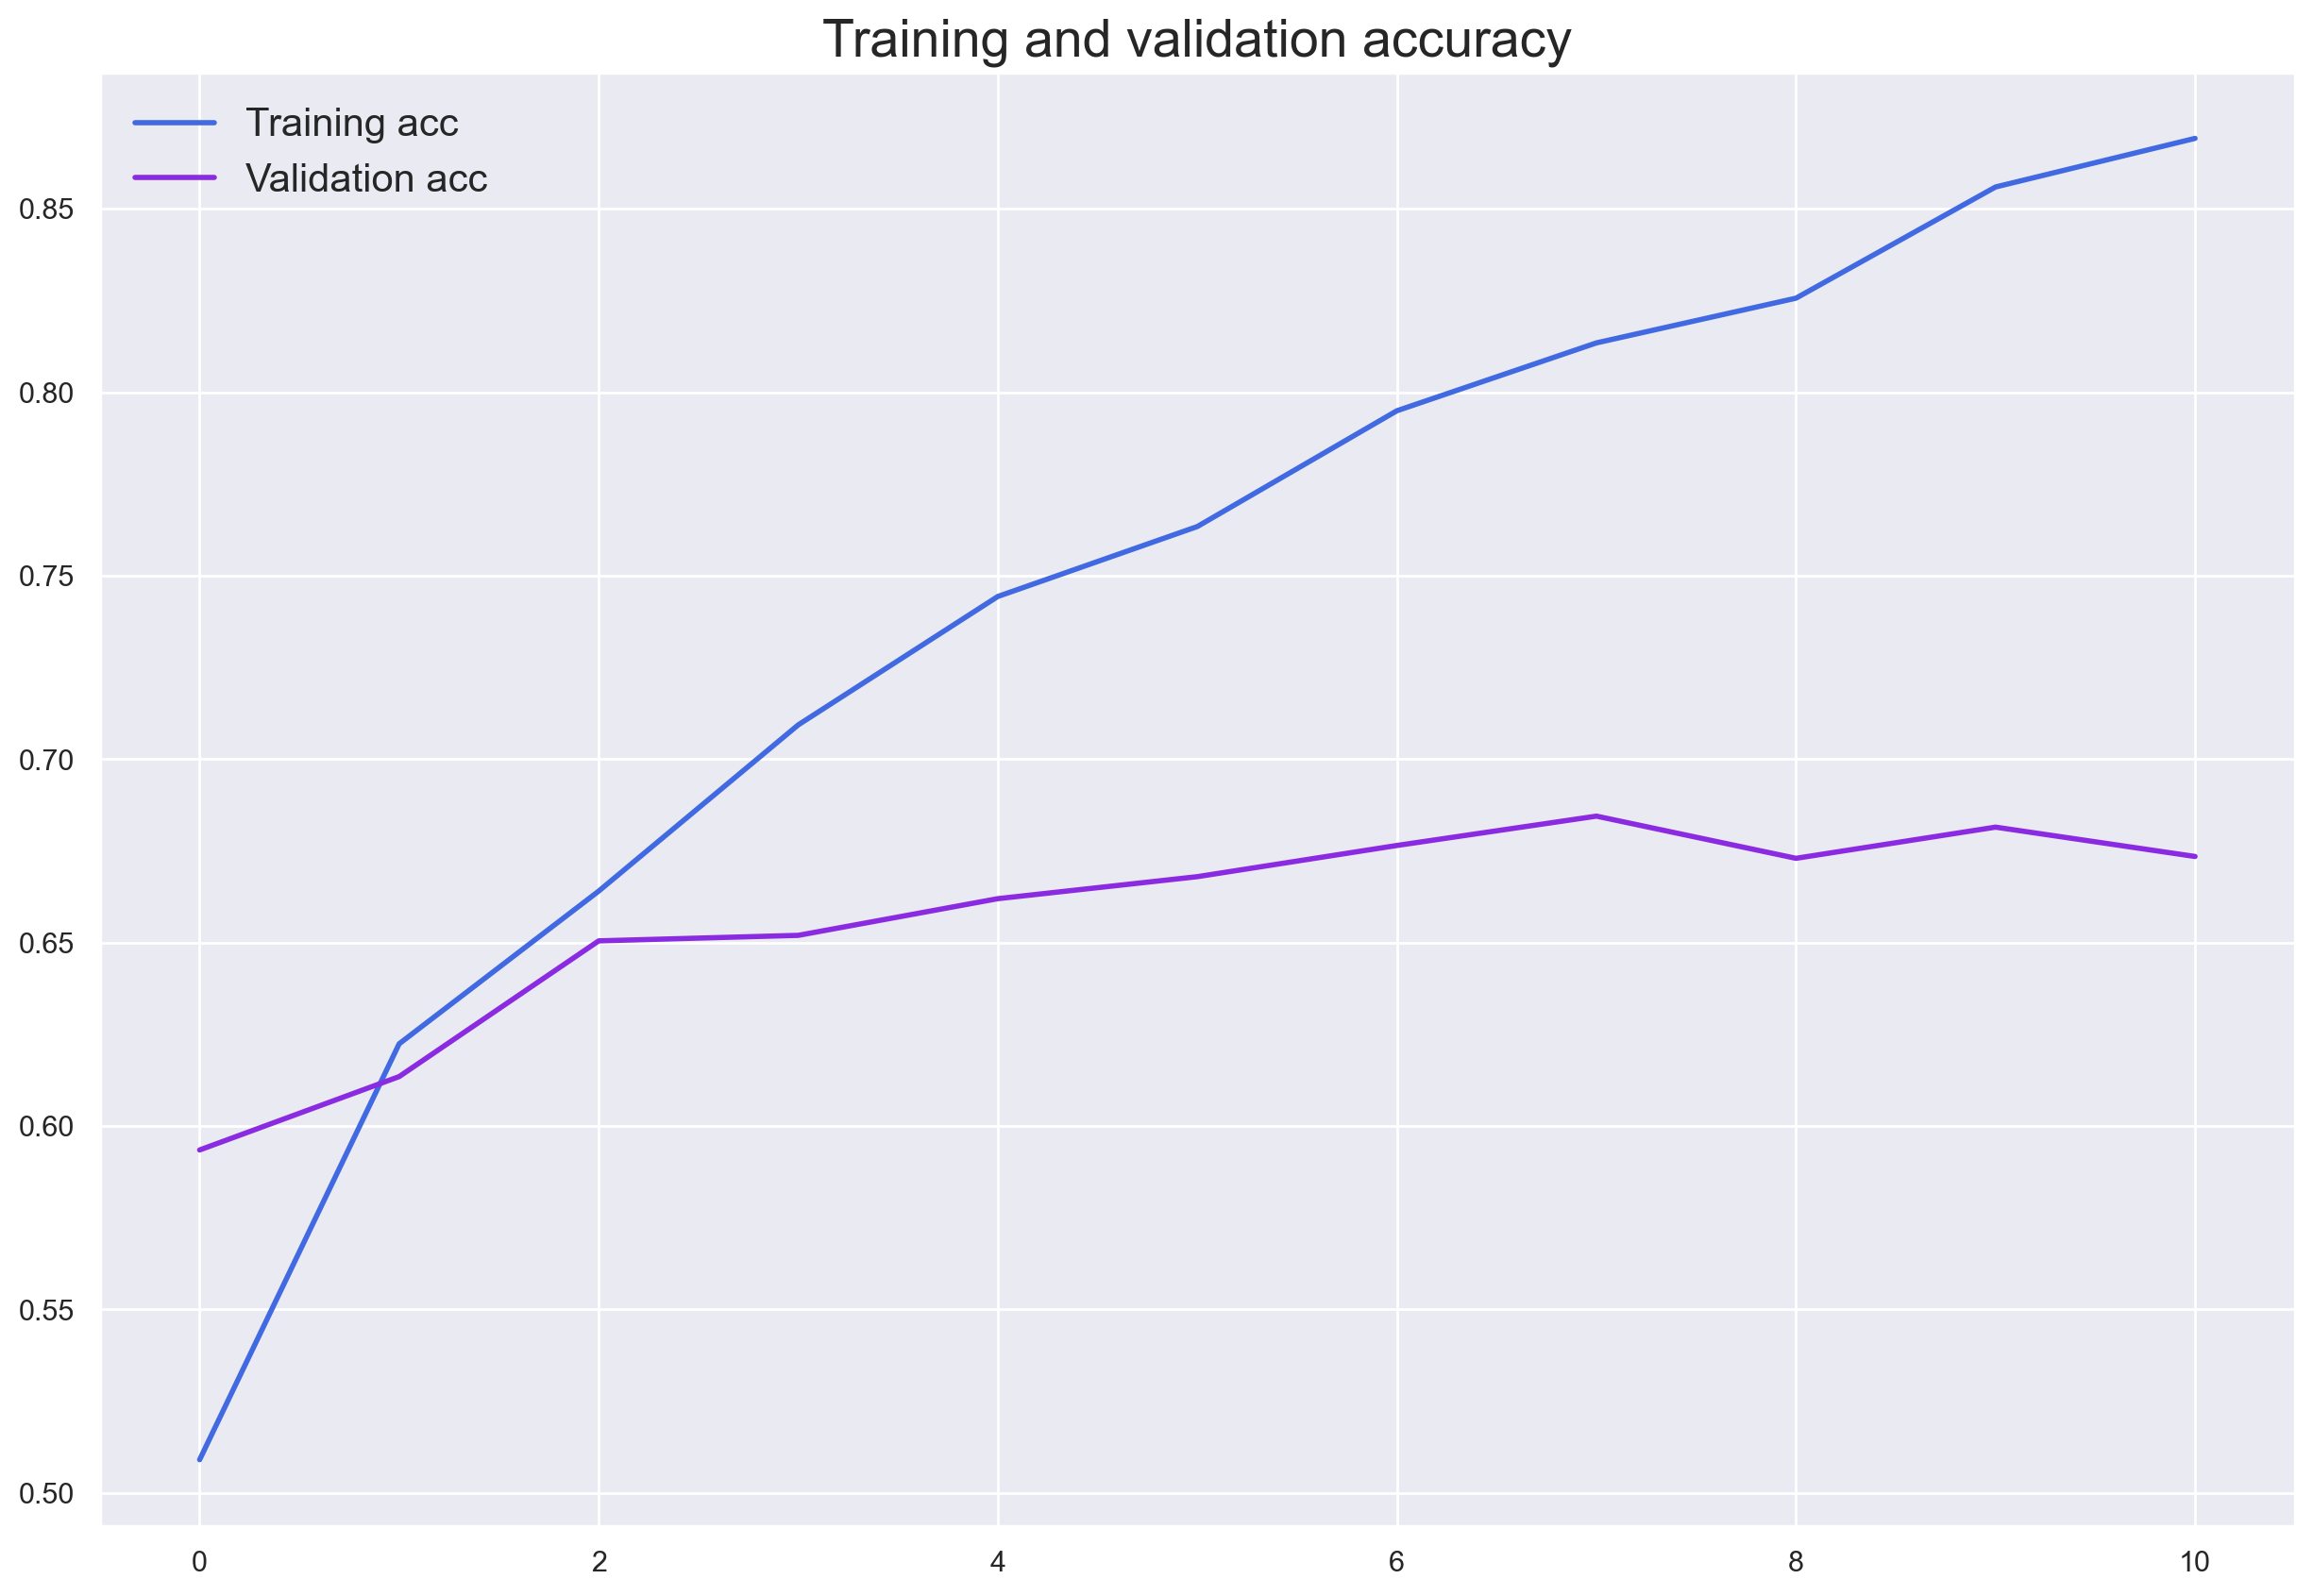

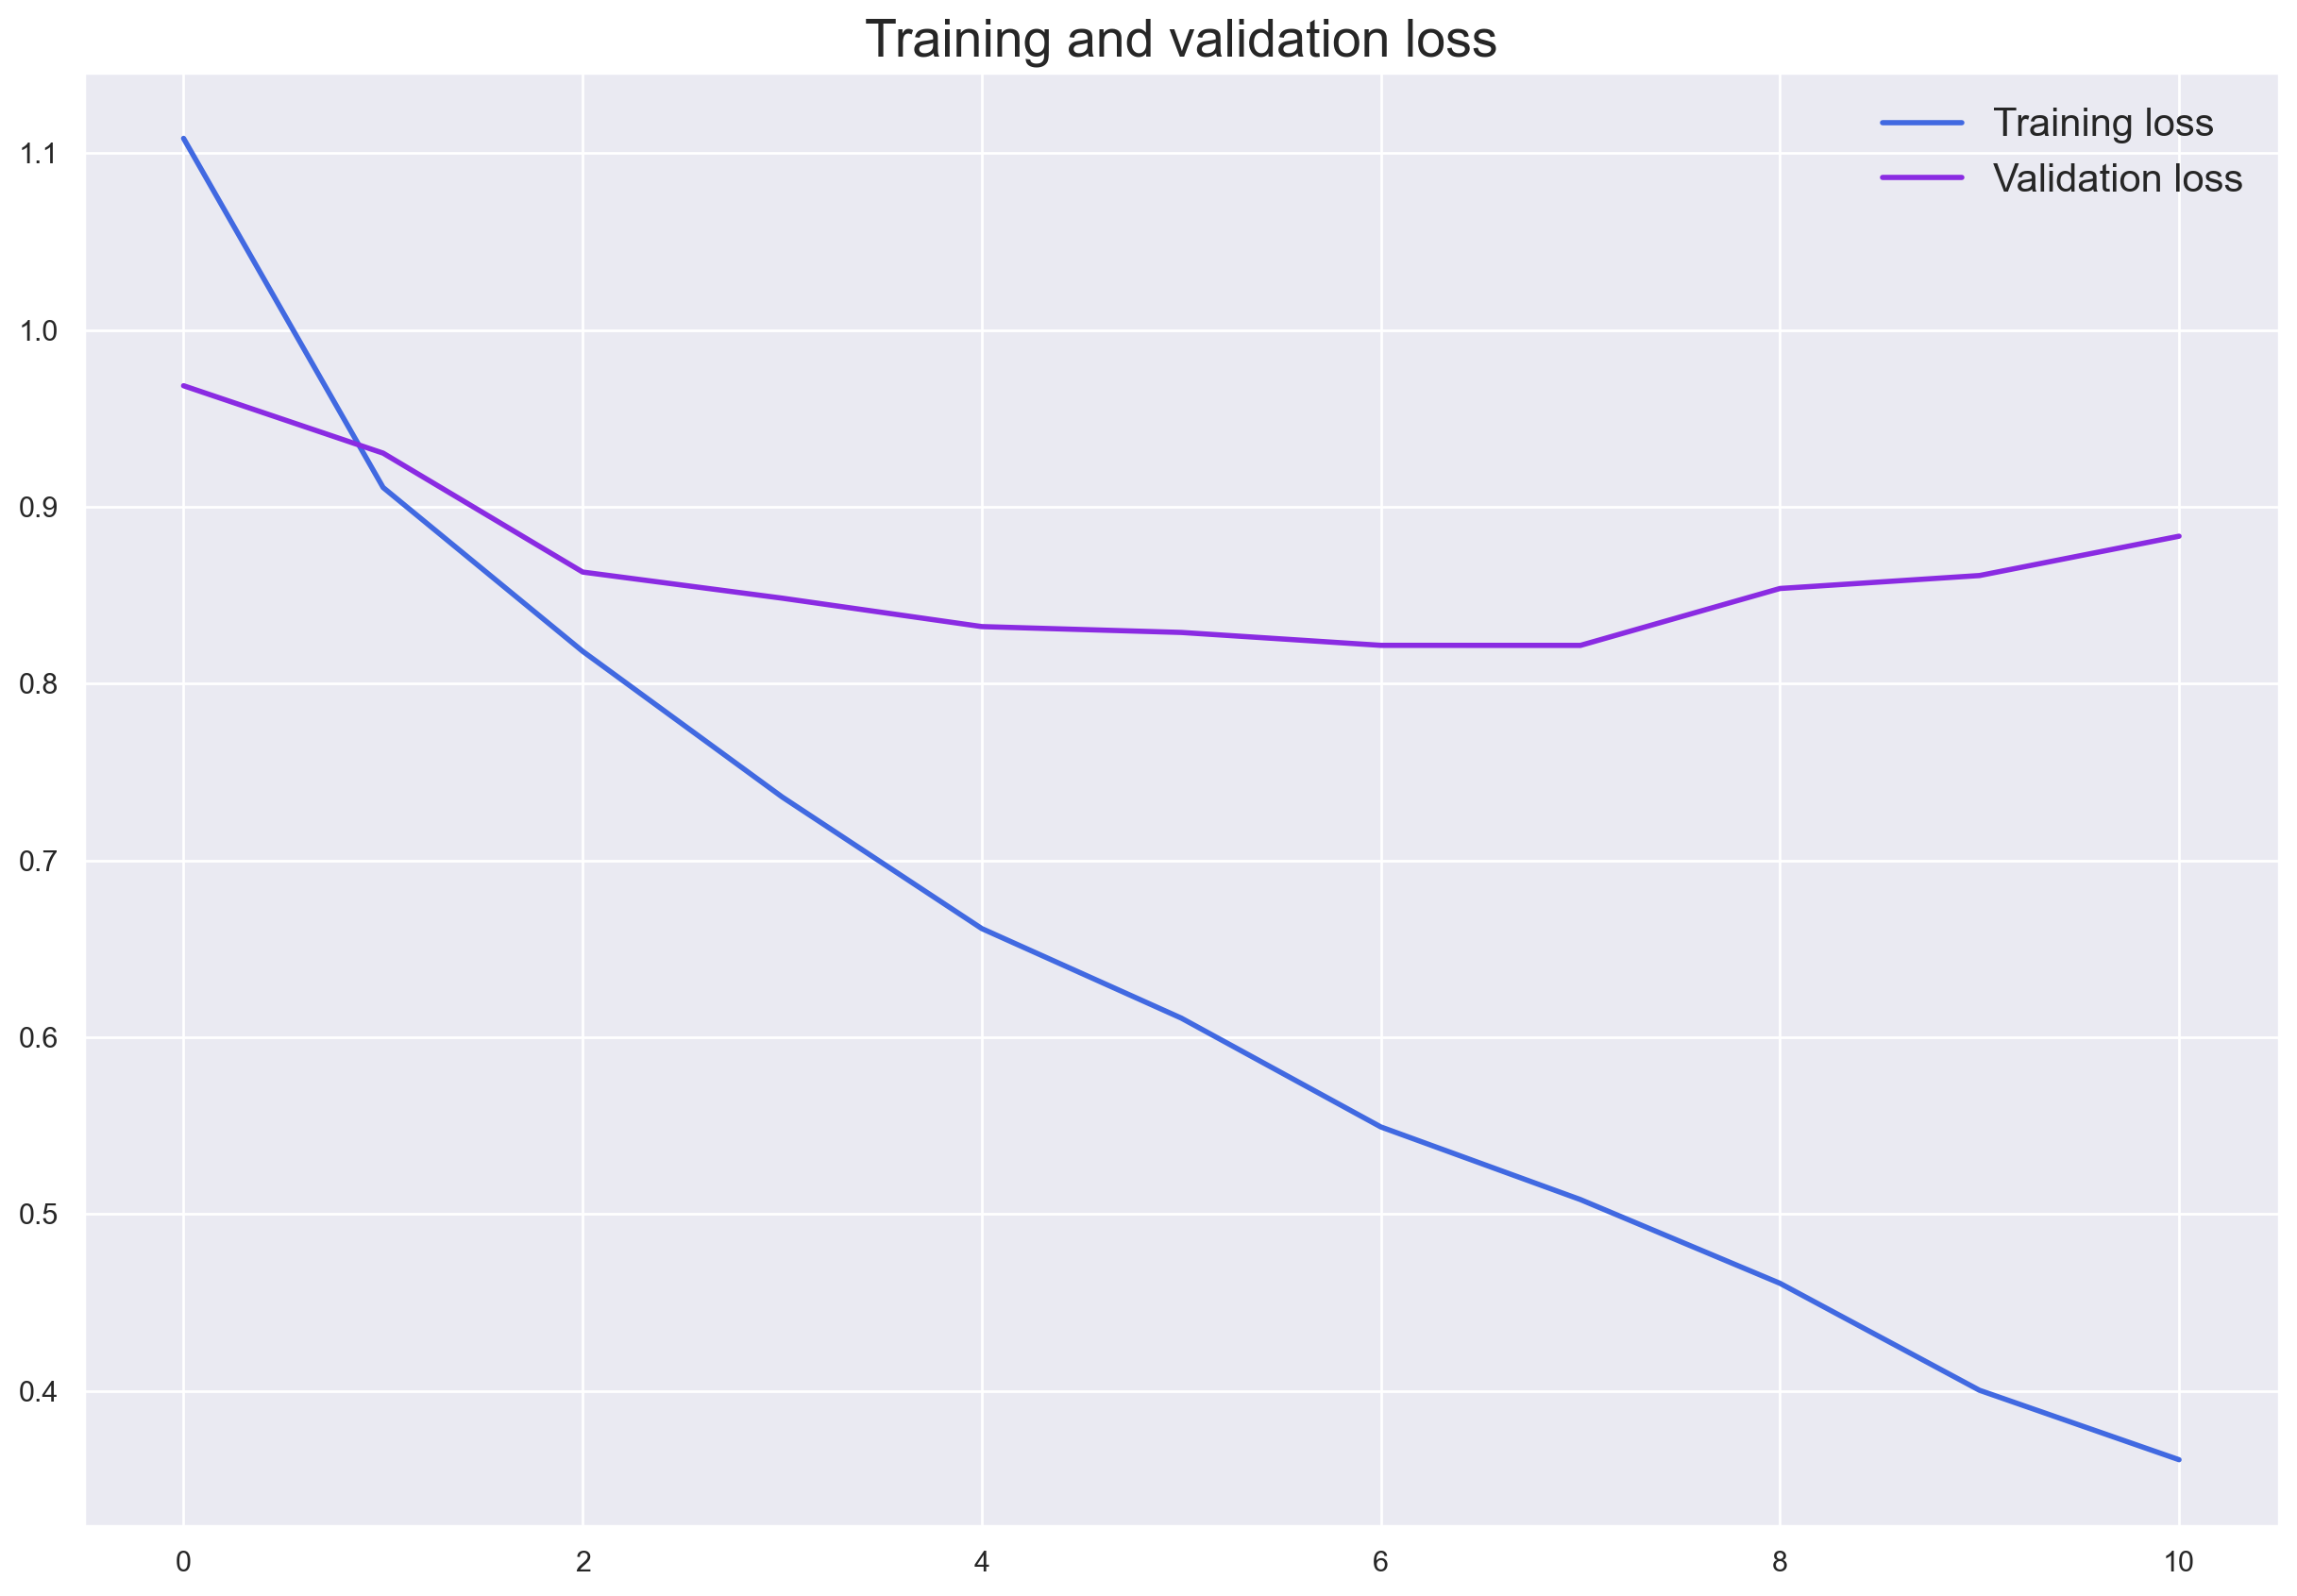

In [149]:
sns.set_theme()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, acc, 'royalblue', linewidth=2, label='Training acc')
plt.plot(epochs, val_acc, 'blueviolet', linewidth=2, label='Validation acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend(frameon=False, fontsize=15)

plt.show()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, loss, 'royalblue', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'blueviolet', linewidth=2, label='Validation loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend(frameon=False, fontsize=15)
plt.show()

In [150]:
model.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.8935 - acc: 0.6700


[0.8935467004776001, 0.6700000166893005]